<a href="https://colab.research.google.com/github/Shu-Hsuan-Lin/MachineLeaning/blob/main/ML_Practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Some libraries we need


In [ ]:
!pip install netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import netCDF4 as nc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report , ConfusionMatrixDisplay

Input data

In [ ]:
dinput = nc.Dataset('/content/data.nc')
X = dinput.variables['theta'][:,:]
y = dinput.variables['INV'][:]
levs = dinput.variables['level'][:]
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=69)

In [ ]:
print('X train size: ',X_train.shape)
print('X test size : ',X_test.shape)
print('y train size: ',y_train.shape)
print('y test size : ',y_test.shape)


print(X_train[50,:])
print(y_train[50])

X train size:  (6309, 27)
X test size :  (3108, 27)
y train size:  (6309,)
y test size :  (3108,)
[370.12698 359.5477  356.03815 350.6932  348.11057 346.2215  343.72122
 341.3398  332.9905  328.2245  325.28085 321.81    318.73407 316.02777
 312.9631  309.68277 306.6069  305.22876 303.2746  298.2535  294.09003
 292.5531  291.99774 291.72256 291.7343  291.7389  291.71378]
1


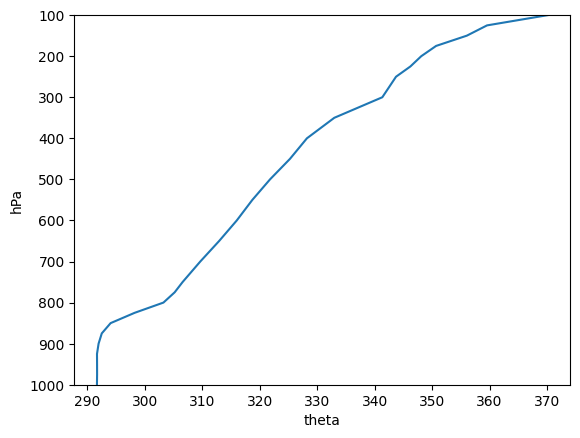

In [ ]:
plt.plot(X_train[50,:],levs)
plt.ylim(1000,100)
plt.xlabel('theta')
plt.ylabel('hPa')
plt.show()
plt.close()

Standardize input data

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [ ]:
print('After scaling')
print(X_train[5,:])

After scaling
[-1.0415298  -0.34705386 -0.2943208  -0.4400626  -0.31446162  0.04533595
  0.29531646  0.48557866  0.48380035 -0.1298     -0.1306477   0.19535525
  0.42932895  0.63930947  0.74438703  0.4569615  -0.34599337 -0.32148203
 -0.16556145 -0.11581702 -0.04929522 -0.02797515 -0.02140792 -0.01273459
 -0.00882331  0.0982089   0.11389271]


Parameters for training

In [ ]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.00001


Define custom data loader

In [ ]:
## train data
class TrainData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)
train_data = TrainData(torch.FloatTensor(X_train),
                       torch.FloatTensor(y_train))


In [ ]:
## test data
class TestData(Dataset):


    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]

    def __len__ (self):
        return len(self.X_data)


test_data = TrainData(torch.FloatTensor(X_test),torch.FloatTensor(y_test))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE,
               shuffle=True)

test_loader = DataLoader(dataset=test_data, batch_size=1)


Define neural net architecture
Note that the structure of input features

In [ ]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()

        # Number of input features is 27.
        self.layer_1 = nn.Linear(27,64)
        self.layer_2 = nn.Linear(64,64)
        self.layer_out = nn.Linear(64,1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self,inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)


cpu


In [ ]:
model = BinaryClassification()
model.to(device)

print(model)


BinaryClassification(
  (layer_1): Linear(in_features=27, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)



Train the model

In [ ]:
def train(dataloader, model, loss_fn,optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        #Compute prediction error
        pred = model(X)
        loss = loss_fn(pred,y.unsqueeze(1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
for X, y in test_loader:
    X, y = X.to(device), y.to(device)


Test the model

In [ ]:
def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y.unsqueeze(1)).item() # a+=b   (a=a+b)
            y_pred_tag = torch.round(torch.sigmoid(pred)) 
            correct_results_sum = (y_pred_tag == y.unsqueeze(1)).sum().float()
            correct += correct_results_sum.type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct*100

In [ ]:
total_trainloss= np.zeros((EPOCHS))
total_testloss= np.zeros((EPOCHS))
total_acc = np.zeros((EPOCHS))

for t in range(EPOCHS):
    print('EPOCH:', t+1)
    train(train_loader,model,loss_fn,optimizer)
    print('Train-------------------------------')
    trainloss,acc1 = test(train_loader, model, loss_fn)
    print('Test--------------------------------')
    testloss,acc  = test(test_loader,model,loss_fn)

    total_trainloss[t] = trainloss
    total_testloss[t]  = testloss
    total_acc[t]       = acc


EPOCH: 1
Train-------------------------------
Error: 
 Accuracy: 47.9%, Avg loss: 0.716120 

Test--------------------------------
Error: 
 Accuracy: 47.7%, Avg loss: 0.714450 

EPOCH: 2
Train-------------------------------
Error: 
 Accuracy: 49.6%, Avg loss: 0.702870 

Test--------------------------------
Error: 
 Accuracy: 49.4%, Avg loss: 0.700665 

EPOCH: 3
Train-------------------------------
Error: 
 Accuracy: 53.0%, Avg loss: 0.686076 

Test--------------------------------
Error: 
 Accuracy: 52.8%, Avg loss: 0.684163 

EPOCH: 4
Train-------------------------------
Error: 
 Accuracy: 56.3%, Avg loss: 0.670517 

Test--------------------------------
Error: 
 Accuracy: 56.0%, Avg loss: 0.668245 

EPOCH: 5
Train-------------------------------
Error: 
 Accuracy: 57.9%, Avg loss: 0.663673 

Test--------------------------------
Error: 
 Accuracy: 58.5%, Avg loss: 0.661436 

EPOCH: 6
Train-------------------------------
Error: 
 Accuracy: 60.0%, Avg loss: 0.651951 

Test------------------

Plot train and test loss

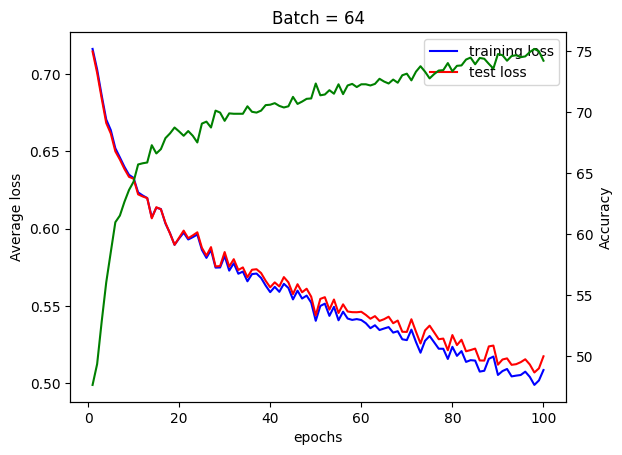

In [ ]:
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1,EPOCHS+1),total_trainloss,'b',np.arange(1,EPOCHS+1),total_testloss,'r')
ax2.plot(np.arange(1,EPOCHS+1),total_acc,'g')


ax1.legend(["training loss","test loss"])
ax1.set_ylabel("Average loss")
ax1.set_xlabel("epochs")
ax2.set_ylabel('Accuracy')
plt.title("Batch = " + str("%.0f"%BATCH_SIZE))

#plt.savefig('loss.png')

plt.show()
#plt.close()


Confusion matrix

In [ ]:
model.eval()
pred_result = np.zeros((len(y_test)))
truth = np.zeros((len(y_test)))
score = np.zeros((len(y_test)))
i=0

for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    pred = model(X)
    pred_result[i]= torch.round(torch.sigmoid(pred))
    score[i] = torch.sigmoid(pred)
    truth[i] = y
    i=i+1


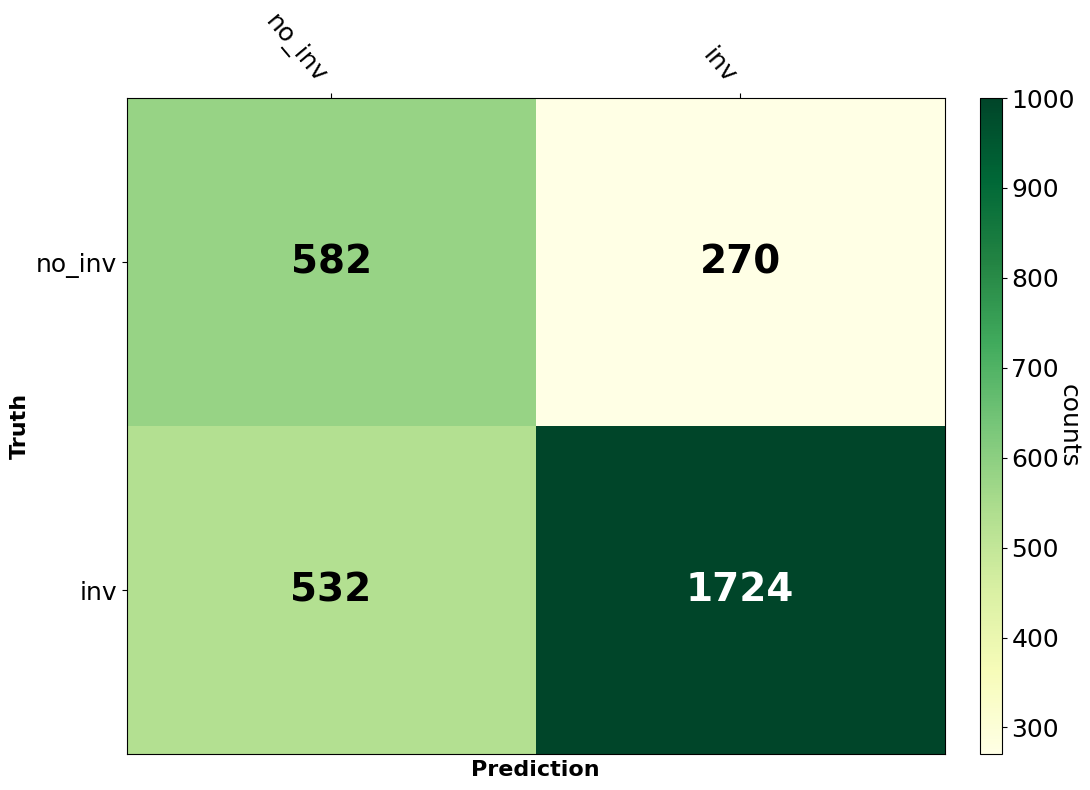

In [ ]:
hist_pred = np.histogram2d(pred_result,truth,bins=2)
nparray_h = hist_pred[0]

classes = ['no_inv','inv']

fig,ax = plt.subplots(figsize=(11,8))

hitplot = ax.pcolormesh(nparray_h.T,cmap='YlGn',vmax=1000)
for xx in range(0,2):
  for yy in range(0,2):
    if nparray_h[xx,yy] > 700:
      ax.text(xx+0.5, yy+0.5, int(nparray_h[xx,yy]),color='w', size=28,fontweight='semibold',ha='center',va='center')
    else:
      ax.text(xx+0.5, yy+0.5, int(nparray_h[xx,yy]),color='k', size=28,fontweight='semibold',ha='center',va='center')
ax.invert_yaxis()
plt.ylabel('Truth',fontsize=16,fontweight='semibold',rotation=90)
plt.xlabel('Prediction',fontsize=16,fontweight='semibold')
plt.xticks(np.arange(0.5,2,1),classes,fontsize=18,rotation=310,horizontalalignment='right')
ax.xaxis.tick_top()
plt.yticks(np.arange(0.5,2,1),classes,fontsize=18)
cb = plt.colorbar(hitplot,aspect=30,fraction=0.03, pad=0.04)
cb.ax.tick_params(labelsize=18)
cb.set_label('counts', size=18,rotation=270)
plt.tight_layout()

plt.show()